# Starbucks Capstone Challenge

Yu Tao 05/02/2021

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Define

Understanding the customer behavior on the Starbucks rewards mobile app, specifically, the customer response to different offers, will help the company provide better customer experiences and increase the revenue. In this project, I would like to bulid a machine learning classification model to predict whether a customer will respond to certain offers, based on the customer’s transactions and demographic information.

If a customer completed an offer within the validity period, the customer responded to the offer successfully. To build a classification model and predict the customer response to offers, the key step is to label the data based on the customer transactions, separating successful responses (label ‘1’) from unsuccessful ones (label ‘0’). This procedure could be tricky since certain customers might make a purchase without having received an offer or seen an offer. Besides, some demographic groups will make purchases even if they don't receive an offer. Different groups need to be assessed before we assign the labels. Afterwards, we will select features from the customer demographic and the offer type information so that the machine learning model can learn from it.

To evaluate the performance of the classification model, we will compare the train/test accuracy. Accuracy is defined as (true positives + true negatives)/dataset size. In general, a higher test accuracy indicates a better classification model. However, accuracy scores are not always informative, especially when the data labels are imbalanced. Therefore, the f1-scores (precision, recall) will also be evaluated, where false positives and false negatives are also included.

In [1]:
# import libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import calendar
import json
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from time import time

import warnings
warnings.filterwarnings('ignore')

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Analyze

A brief overview of the three json file were provided below.

## explore portfolio

In [2]:
# shape of portfolio dataframe
portfolio.shape

(10, 6)

In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


The ‘portfolio’ file contains offer ids and meta data about each offer (duration, type, etc.). ‘Channels’ specifies platforms where the offers were launched, ‘difficulty’ and ‘reward’ indicate the minimum amount in dollars needed to spend in order to use the offer and the reward to be expected from the offer, whereas the ‘duration’ shows the validity period of each offer. Dummy variables were assigned to the ‘channels’ column so we can use channels as part of the features to build our model.

In [4]:
# create dummy variables for the channels
portfolio['email'] = [1 if 'email' in channel else 0 for channel in portfolio.channels]
portfolio['mobile'] = [1 if 'mobile' in channel else 0 for channel in portfolio.channels]
portfolio['social'] = [1 if 'social' in channel else 0 for channel in portfolio.channels]
portfolio['web'] = [1 if 'web' in channel else 0 for channel in portfolio.channels]

In [5]:
portfolio

,channels,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


In [6]:
# get dummy variables for the offer type
offer_type = pd.get_dummies(portfolio.offer_type)
portfolio = pd.concat([portfolio, offer_type], axis=1, sort=False)

In [7]:
portfolio

,channels,difficulty,duration,id,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1,0,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,1,0,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,0,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,0,1,0
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1,0,1,0
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1,0,1,0
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0,0,0,1
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,1,0,0
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1,0,1,0


## explore profile

In [8]:
# shape of profile dataframe
profile.shape

(17000, 5)

In [9]:
# head of profile dataframe
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [10]:
# basic info of profile dataframe
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [11]:
# check NaN in the profile dataframe
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

Text(0.5, 1.0, 'Customer Age Distribution')

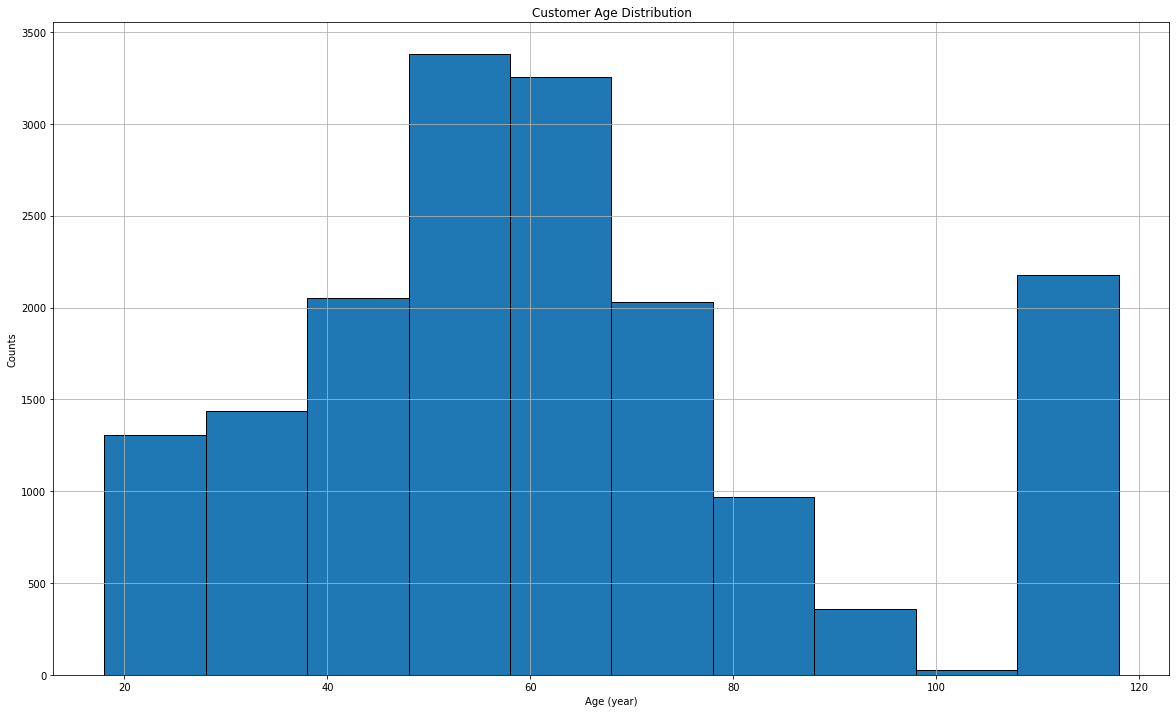

In [12]:
# plot the customer age distribution
plt.figure()
profile.age.hist(figsize = (20,12), edgecolor='black')
plt.xlabel('Age (year)')
plt.ylabel('Counts')
plt.title('Customer Age Distribution')

The ‘profile’ file shows demographic data of each customer, including the age, membership time, gender, id and income. There are missing values in the gender and income columns, it is also noted that ages like 118 are present. 

In [13]:
# check NaN in the 118 age group
profile[profile.age == 118].isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [14]:
# number of unique users
profile.id.nunique()

17000

In ‘profile’ file, there are 17000 unique person ids, and 2175 missing values from both the ‘gender’ and ‘income’ columns. From the age histogram, there is an anomaly at the age of 118. If we check the missing values from a subset of ‘profile’ where we specify the age to be 118, exactly 2175 missing values in ‘gender’ and ‘income’ columns were found.

Text(0.5, 1.0, 'Customer Income Distribution')

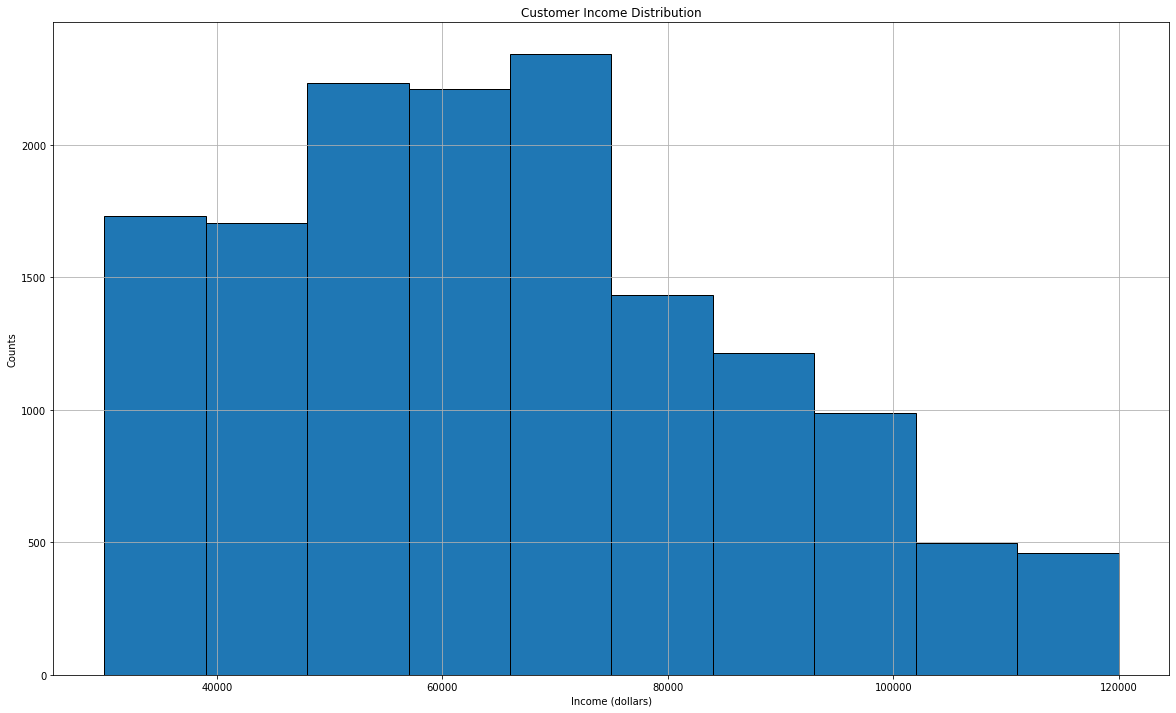

In [15]:
# plot customer income distribution
plt.figure()
profile.income.hist(figsize = (20,12), edgecolor='black')
plt.xlabel('Income (dollars)')
plt.ylabel('Counts')
plt.title('Customer Income Distribution')

Text(0.5, 1.0, 'Customer Gender Distribution')

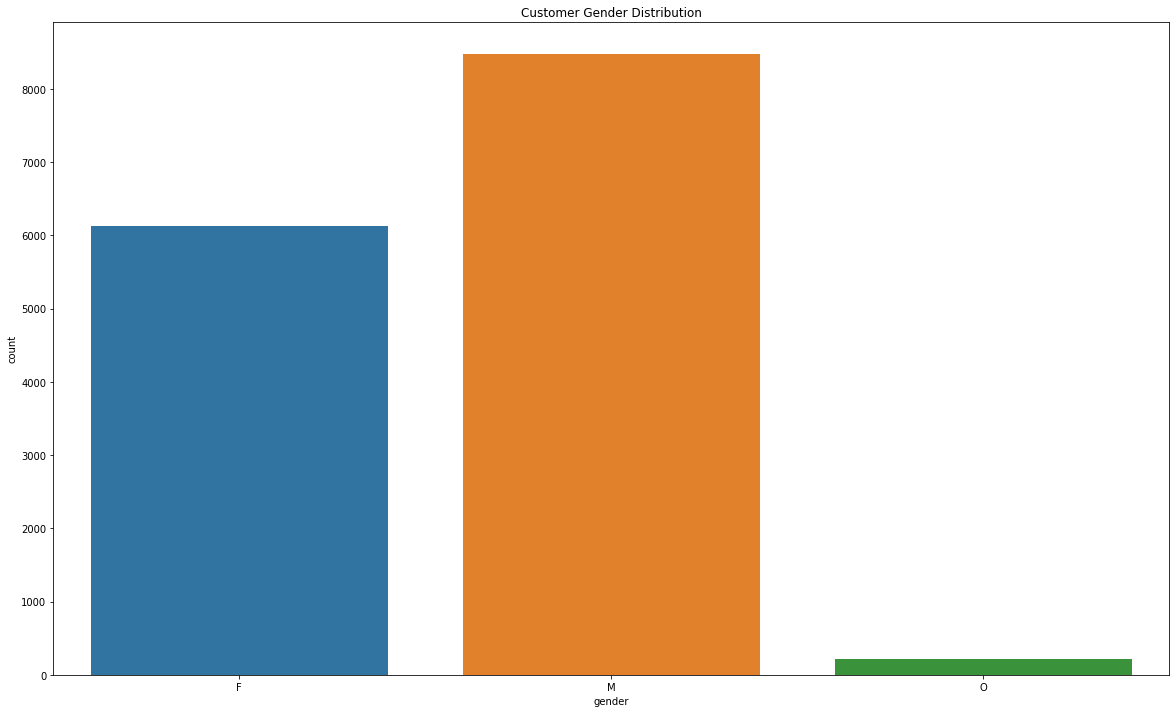

In [16]:
# plt customer gender distribution
plt.figure(figsize = (20,12))
sns.countplot(x = "gender", data = profile)
plt.title('Customer Gender Distribution')

There are over 2000 more female customers than males in our data set. 

Text(0.5, 1.0, 'Customer Income Distribution by Gender')

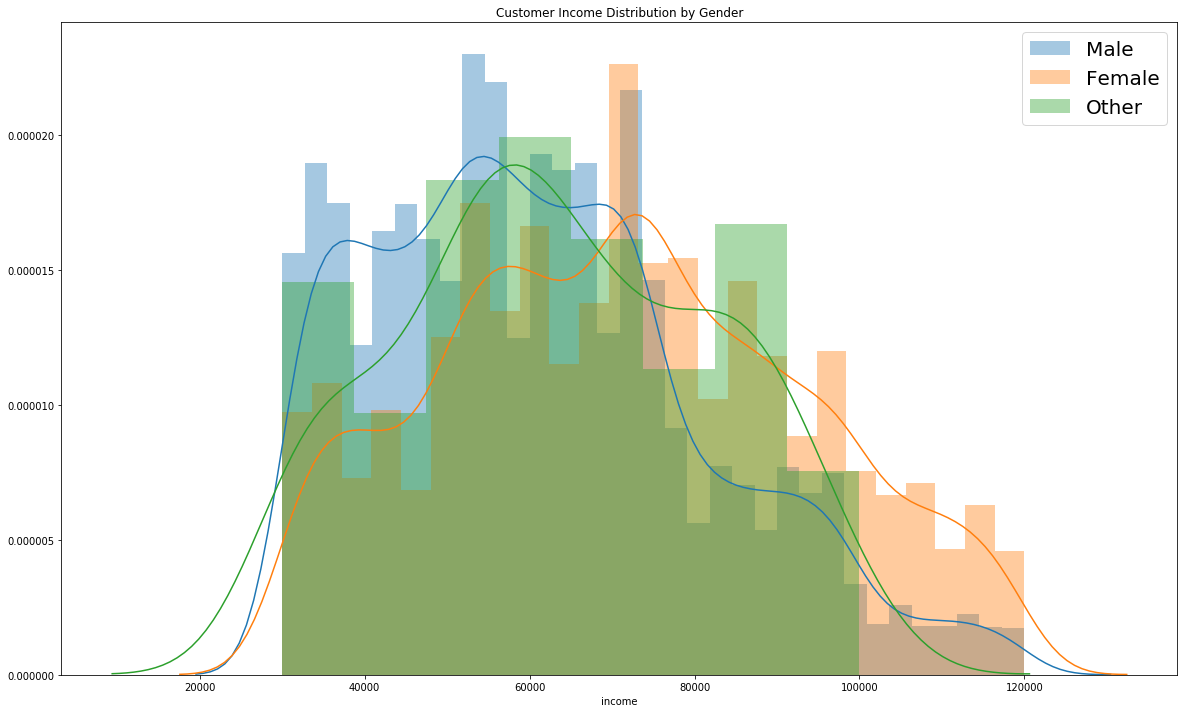

In [17]:
# plot customer income distribution by gender
plt.figure(figsize = (20,12))
sns.distplot(profile[profile.gender == 'M'].income, label='Male')
sns.distplot(profile[profile.gender == 'F'].income, label='Female')
sns.distplot(profile[profile.gender == 'O'].income, label='Other')
plt.legend(fontsize = 20)
plt.title('Customer Income Distribution by Gender')

Text(0.5, 1.0, 'Customer Age Distribution by Gender')

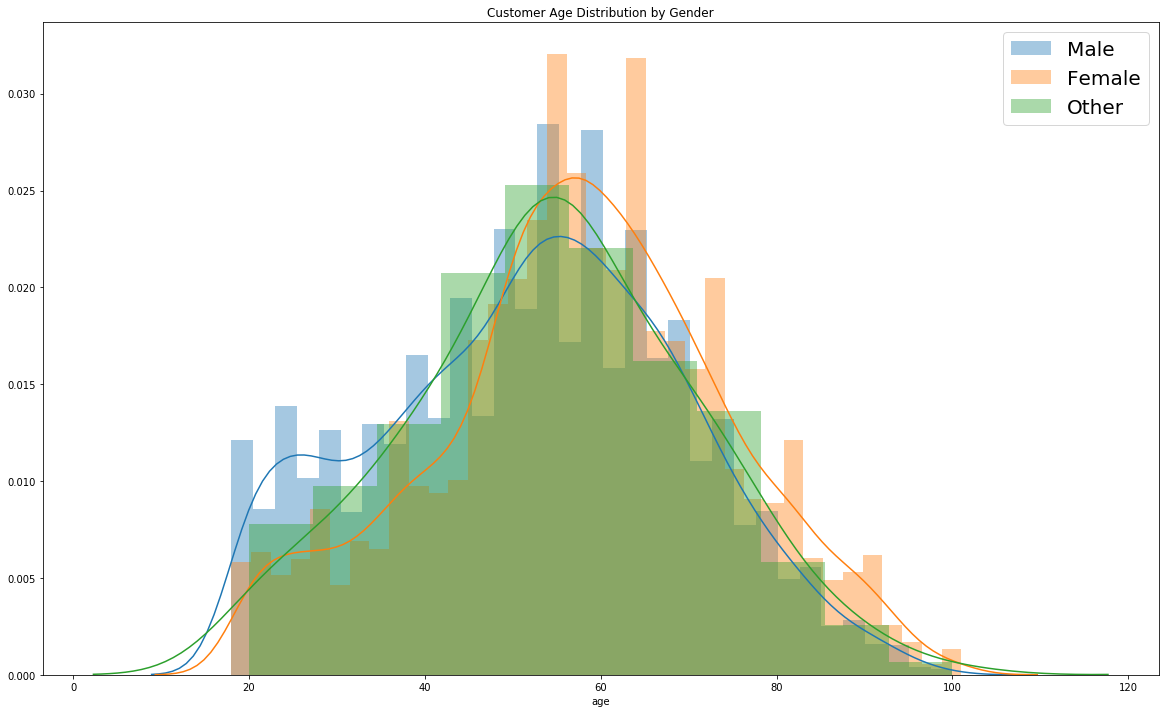

In [18]:
# plot customer age distribution by gender
plt.figure(figsize = (20,12))
sns.distplot(profile[profile.gender == 'M'].age, label='Male')
sns.distplot(profile[profile.gender == 'F'].age, label='Female')
sns.distplot(profile[profile.gender == 'O'].age, label='Other')
plt.legend(fontsize = 20)
plt.title('Customer Age Distribution by Gender')

Their income and age distributions by gender were further looked at (they are not affected by the missing values). From the income distribution, the most frequent incomes are from those who annually earn 50000 to 70000 dollars. From the age distribution, more customers are from the 50 to 60 age group.

I converted the entries in the ‘became_member_on’ from string format into datetime and extract the corresponding membership year, month and day information.

In [19]:
# convert became_member_on from string (object) format to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [20]:
# head of profile
profile.head()

,age,became_member_on,gender,id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [21]:
# check the datetime format is implemented
profile.iloc[0]['became_member_on']

Timestamp('2017-02-12 00:00:00')

In [22]:
# extract membership year month and day information for each customer
profile['member_year'] = [dt.year for dt in profile.became_member_on]
profile['member_month'] = [dt.month for dt in profile.became_member_on]
profile['member_day'] = [calendar.day_name[dt.weekday()] for dt in profile.became_member_on]

In [23]:
# head of profile
profile.head()

,age,became_member_on,gender,id,income,member_year,member_month,member_day
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,Sunday
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,Saturday
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,Thursday
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,Tuesday
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN,2017,8,Friday


Text(0.5, 1.0, 'Customer membership year by gender')

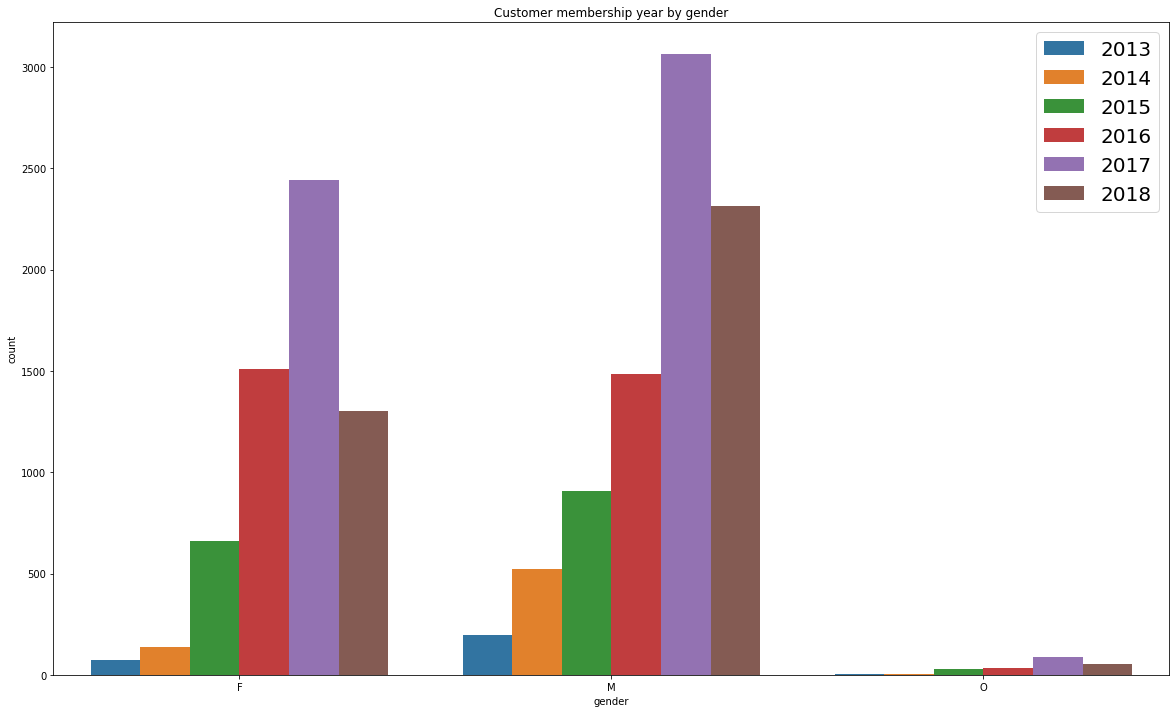

In [24]:
# plot customer membership year by gender
plt.figure(figsize = (20,12))
sns.countplot(x = "gender", hue = "member_year", data = profile)
plt.legend(fontsize = 20)
plt.title('Customer membership year by gender')

From the membership starting year distribution by gender (extracted from the ‘became_member_on’ column mentioned above), there is definitely an increase in the number of customers since 2013. Year 2018 does not show the trend since we only have data from the first few months.

## explore transcript

In [25]:
# shape of transcript dataframe
transcript.shape

(306534, 4)

In [26]:
# head of transcript dataframe
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [27]:
# info of transcript dataframe
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [28]:
# count the number of events
transcript.groupby('event').value.count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: value, dtype: int64

Text(0.5, 1.0, 'Transcript event counts')

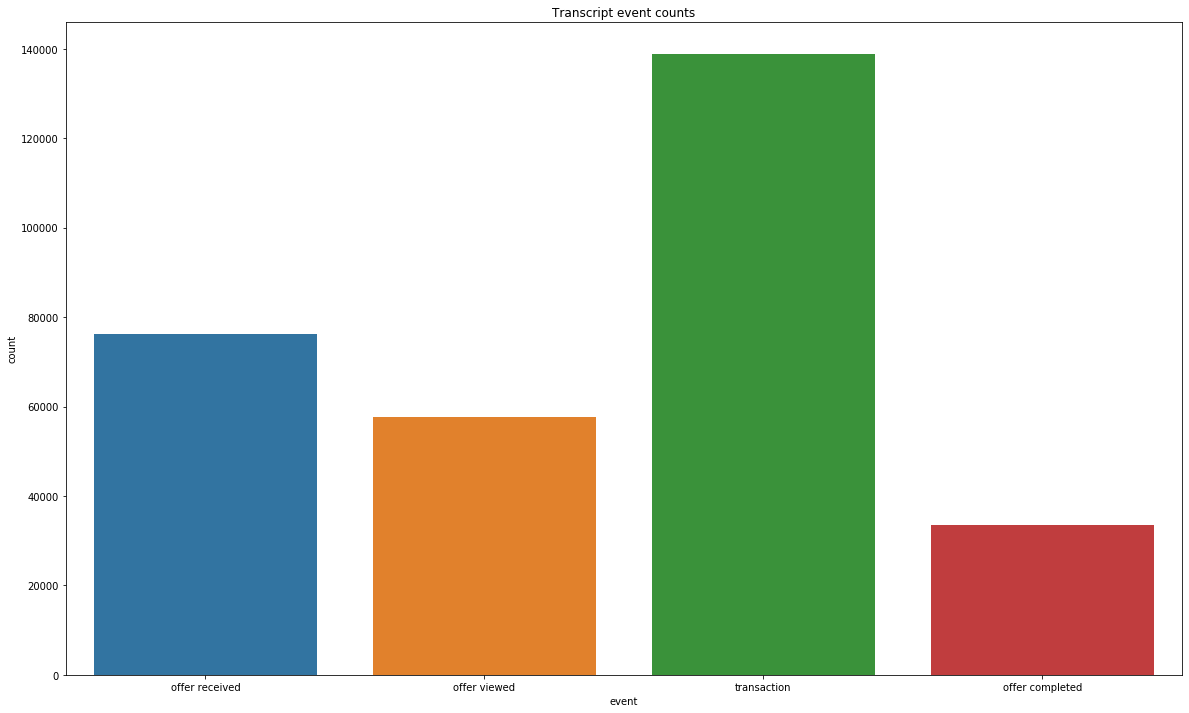

In [29]:
# plot event counts
plt.figure(figsize = (20,12))
sns.countplot(x = "event", data = transcript)
plt.title('Transcript event counts')

From the ‘transcript’ file, about 140000 transaction events, 75000 offer received events, 60000 offer viewed events and 35000 offer completed events are recorded.

In [30]:
# check on the time variable
transcript.groupby('time').value.count()

time
0      15561
6       2506
12      2215
18      2015
24      1921
30      1896
36      1732
42      1650
48      1610
54      1519
60      1428
66      1487
72      1373
78      1308
84      1323
90      1235
96      1248
102     1193
108     1104
114     1106
120     1168
126      983
132      952
138      968
144      955
150      894
156      914
162      910
168    16150
174     2823
       ...  
540     2296
546     2192
552     1995
558     1943
564     1928
570     1892
576    17015
582     3484
588     3222
594     2937
600     2739
606     2585
612     2375
618     2306
624     2174
630     1961
636     1934
642     1861
648     1801
654     1599
660     1599
666     1611
672     1595
678     1351
684     1384
690     1260
696     1326
702     1115
708     1048
714     1130
Name: value, Length: 120, dtype: int64

In [31]:
# check number of unique customers
transcript.person.nunique()

17000

In [32]:
# explore the value column
transcript.value

0          {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1          {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2          {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3          {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4          {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5          {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6          {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7          {'offer id': '3f207df678b143eea3cee63160fa8bed'}
8          {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9          {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
10         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
11         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
12         {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
13         {'offer id': '3f207df678b143eea3cee63160fa8bed'}
14         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
15         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
16         {'offer id': '0b1e1539f2cc45b

The ‘transcript’ file includes records for transactions, offers received, offers viewed, and offers completed from each customer. These four customer records are indicated in the ‘event’ column. The ‘person’ and ‘time’ columns specify the person id (same as the ‘id’ column in the profile data set) and time in hour (starting from 0) associated with each record. In the ‘value’ column, if the record is either offers received, offers viewed or offers completed, it will be linked to the ‘offer_id’. Offers completed will also have ‘reward’ shown from the purchases. If the record is from transaction, the event will provide the purchase ‘amount’ in dollars.

Using df.apply(pd.Series) method on the ‘event’ column in the ‘transcript’ data, we can unstack this column into ‘offer_id’, ‘amount’ and ‘reward’. 

In [33]:
# unstack the dictionaries in the value column
transcript = pd.concat([transcript, transcript.value.apply(pd.Series)], axis=1)
transcript.head()

,event,person,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [34]:
# merge offer_id and offer id colums since they are refering to the same variable
transcript['offer_id_merged']=np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),transcript['offer_id'],transcript['offer id'])
transcript.drop(['value', 'offer id', 'offer_id'],axis=1,inplace=True)
transcript.rename(columns={'offer_id_merged': 'offer_id'},inplace=True)

In [35]:
# head of transcript
transcript.head()

,event,person,time,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [36]:
# check if the number of unique offer is 10 as specified in portfolio
transcript.offer_id.nunique()

10

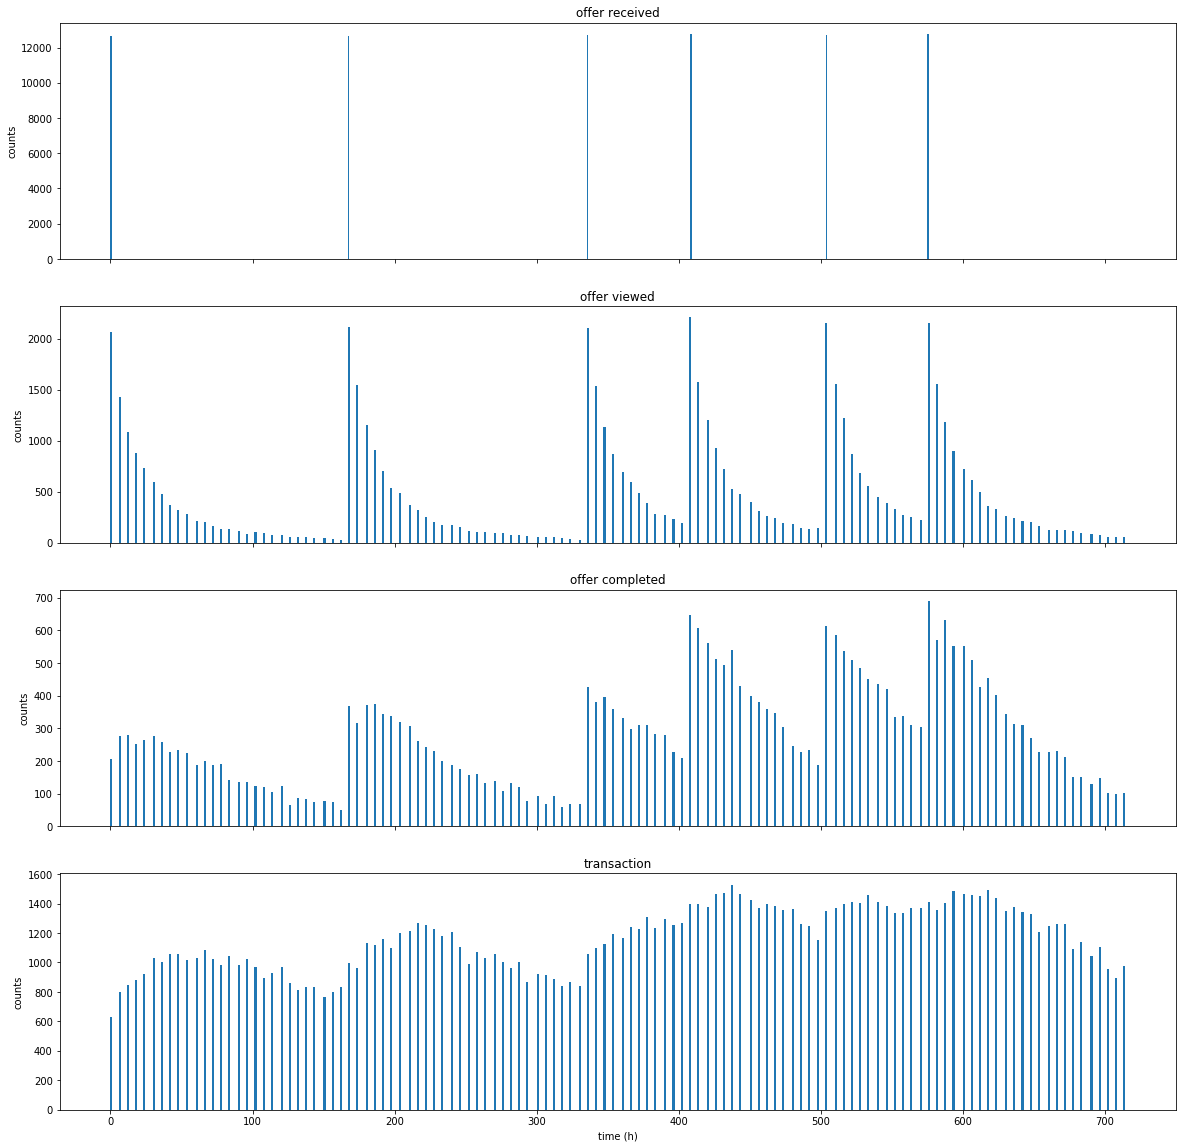

In [37]:
# plot time series of event counts
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(20,20))
ax1 = axes[0]
ax1.hist(transcript[transcript.event == 'offer received']['time'], bins = 500);
ax1.set_title('offer received');
ax1.set_ylabel('counts');
ax2 = axes[1]
ax2.hist(transcript[transcript.event == 'offer viewed']['time'], bins = 500);
ax2.set_title('offer viewed');
ax2.set_ylabel('counts');
ax3 = axes[2]
ax3.hist(transcript[transcript.event == 'offer completed']['time'], bins = 500);
ax3.set_title('offer completed');
ax3.set_ylabel('counts');
ax4 = axes[3]
ax4.hist(transcript[transcript.event == 'transaction']['time'], bins = 500);
ax4.set_title('transaction');
ax4.set_xlabel('time (h)');
ax4.set_ylabel('counts');

From the counts of the four events as functions of time, it is noted that after an offer is released, there is a boost in the number of transactions within the first 24 to 48 hours, which indicates a typical time scale it takes to influence the customers.

## merge transcript and portfolio and further explore

Further visualizations were performed by first merging the ‘transcript’ file and ‘portfolio’ file on the shared ‘offer_id’ column, then counting the events based on either the offer type or channel. 

In [38]:
# rename portfolio column id to offer_id
portfolio.rename(columns={'id': 'offer_id'},inplace=True)
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1,0,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,1,0,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,0,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,0,1,0


In [39]:
# merge transcript and portfolio
transcript_portfolio = transcript.merge(portfolio,how = 'left',on = 'offer_id')

In [40]:
# head of merged dataframe
transcript_portfolio.head()

,event,person,time,amount,reward_x,offer_id,channels,difficulty,duration,offer_type,reward_y,email,mobile,social,web,bogo,discount,informational
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [41]:
# rename columns in the merged dataframe
transcript_portfolio.rename(columns={'amount':'transaction_amount','reward_x':'reward_received','reward_y':'offer_reward'},inplace=True)
transcript_portfolio.head()

,event,person,time,transaction_amount,reward_received,offer_id,channels,difficulty,duration,offer_type,offer_reward,email,mobile,social,web,bogo,discount,informational
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [42]:
# count events by offer type
transcript_portfolio.groupby(['event','offer_type']).offer_type.count()

event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: offer_type, dtype: int64

Text(0.5, 1.0, 'Event counts by offer type')

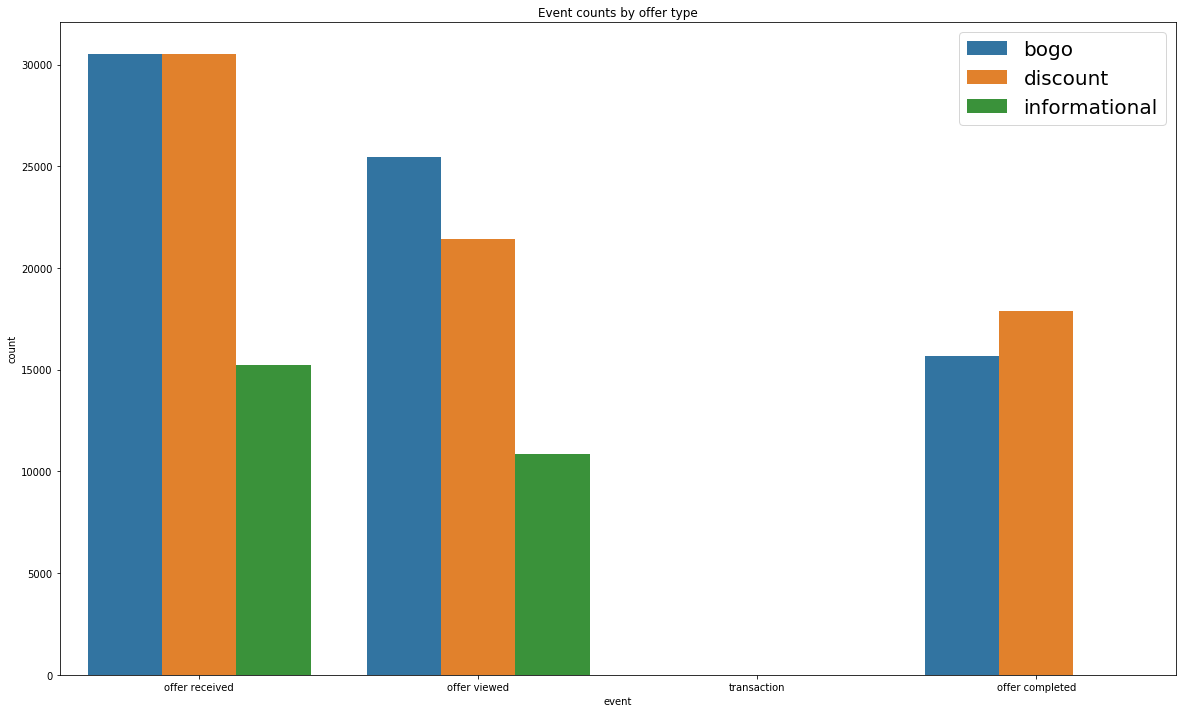

In [43]:
# plot event count by offer type
plt.figure(figsize = (20,12))
sns.countplot(x = "event", hue = "offer_type", data = transcript_portfolio)
plt.legend(fontsize = 20)
plt.title('Event counts by offer type')

Text(0.5, 1.0, 'web')

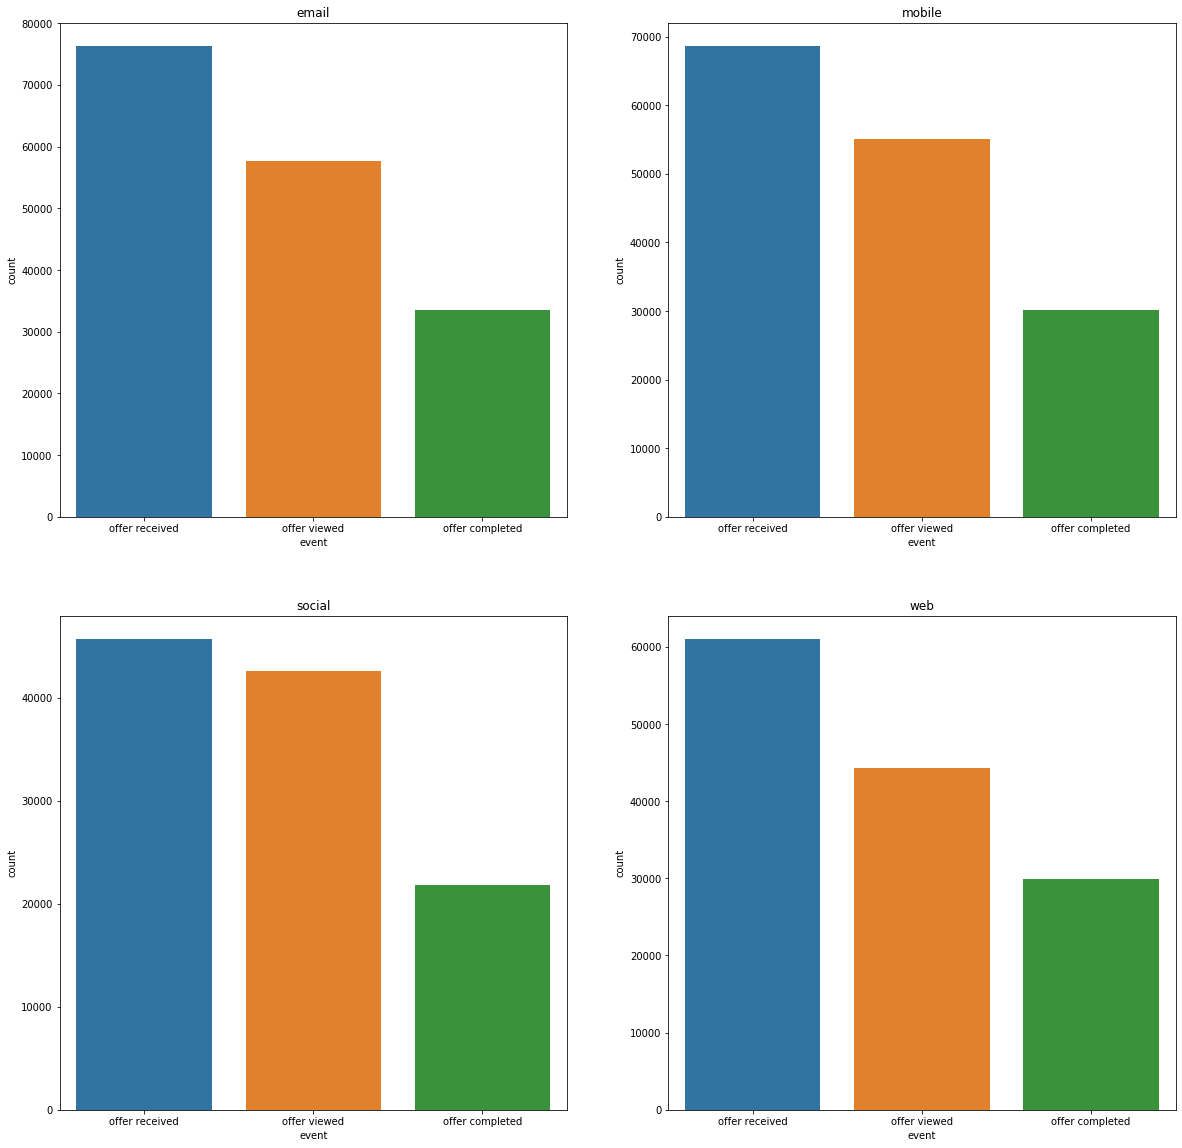

In [44]:
# plot event count by channel
fig, ax = plt.subplots(2, 2, figsize=(20,20))
sns.countplot(x = "event", data = transcript_portfolio[transcript_portfolio.email == 1], ax=ax[0, 0]).set_title('email')
sns.countplot(x = "event", data = transcript_portfolio[transcript_portfolio.mobile == 1], ax=ax[0, 1]).set_title('mobile')
sns.countplot(x = "event", data = transcript_portfolio[transcript_portfolio.social == 1], ax=ax[1, 0]).set_title('social')
sns.countplot(x = "event", data = transcript_portfolio[transcript_portfolio.web == 1], ax=ax[1, 1]).set_title('web')

It is noted that all the transactions are not associated with a certain offer type, and informational offers won’t have an offer completed record once successfully responded. There are 30000 BOGO or discount offers, and 15000 informational offers sent to the customers, with more than half of BOGO and discount offers being completed. 

Comparing the event counts between channels, Starbucks send out more offer to the customers via email than mobile, web or social.

## data preprocessing

To accurately label the successful responses from customers to offers, let’s first understand the time series of the transcript events. From the previously merged transcript_portfolio data shown below, a successful response consists of offer received (R), offer viewed (V), transaction (T) and offer completed (C). it is noted that the last step is not needed for the informational offer. Such process indicates that the customer is aware and committed to the offer, and we will give these responses, if in the validity period, a success label ‘1’. There are three other circumstances. First, R-T-C, R-T, T-C or T, with an optional V after T or C. These behaviors indicate that the customers will make purchases even if not viewing the offer. In other words, these customers are loyal to the Starbucks products anyway. From the business perspective, we would not like to send them offers. Second, R, which means the customers received the offer, but not viewing it. And last, R-V, which means the customers received and viewed the offer, but never made the purchases. It is understandable that the last type of response will be labeled ‘0’, in contrast to the successful ones.

In [45]:
# show merged dataframe in time order
transcript_portfolio = transcript_portfolio.sort_values(['person','time'])

In [46]:
# head of merged dataframe
transcript_portfolio.head(20)

,event,person,time,transaction_amount,reward_received,offer_id,channels,difficulty,duration,offer_type,offer_reward,email,mobile,social,web,bogo,discount,informational
55972,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
89291,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113605,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
153401,offer received,0009655768c64bdeb2e877511632db8f,408,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
168412,transaction,0009655768c64bdeb2e877511632db8f,414,8.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,NaN,5.0,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
204340,offer received,0009655768c64bdeb2e877511632db8f,504,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0


From the explanations above, the key is to understand offer viewed events and transaction events. If there is a transaction happed after an offer viewed from a specific customer to an offer within its validity period, it should be assigned ‘1’, if there is no following offer viewed, or if the offer viewed happened outside the validity period of that offer, it should be labeled ‘0’.
It is noted that transactions do not have associated offer id, therefore, to link transactions to offer viewed events, I will first subset the data to include only offer viewed and transaction event, then forward fill the offer id column for transactions from the previous offer viewed.

In [47]:
# subset only offer viewed or transaction events
viewed_transaction = transcript_portfolio[(transcript_portfolio.event=='offer viewed') | (transcript_portfolio.event=='transaction')][['event','person','time','offer_id']]
viewed_transaction.head(20)

,event,person,time,offer_id
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,5a8bc65990b245e5a138643cd4eb9837
89291,transaction,0009655768c64bdeb2e877511632db8f,228,NaN
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,3f207df678b143eea3cee63160fa8bed
168412,transaction,0009655768c64bdeb2e877511632db8f,414,NaN
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,f19421c1d4aa40978ebb69ca19b0e20d
228422,transaction,0009655768c64bdeb2e877511632db8f,528,NaN
233413,offer viewed,0009655768c64bdeb2e877511632db8f,540,fafdcd668e3743c1bb461111dcafc2a4
237784,transaction,0009655768c64bdeb2e877511632db8f,552,NaN
258883,transaction,0009655768c64bdeb2e877511632db8f,576,NaN
293497,transaction,0009655768c64bdeb2e877511632db8f,660,NaN


In [48]:
# forward fill offer id for the transaction rows
viewed_transaction['offer_id'] = viewed_transaction.offer_id.ffill()
viewed_transaction.head(20)

,event,person,time,offer_id
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,5a8bc65990b245e5a138643cd4eb9837
89291,transaction,0009655768c64bdeb2e877511632db8f,228,5a8bc65990b245e5a138643cd4eb9837
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,3f207df678b143eea3cee63160fa8bed
168412,transaction,0009655768c64bdeb2e877511632db8f,414,3f207df678b143eea3cee63160fa8bed
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,f19421c1d4aa40978ebb69ca19b0e20d
228422,transaction,0009655768c64bdeb2e877511632db8f,528,f19421c1d4aa40978ebb69ca19b0e20d
233413,offer viewed,0009655768c64bdeb2e877511632db8f,540,fafdcd668e3743c1bb461111dcafc2a4
237784,transaction,0009655768c64bdeb2e877511632db8f,552,fafdcd668e3743c1bb461111dcafc2a4
258883,transaction,0009655768c64bdeb2e877511632db8f,576,fafdcd668e3743c1bb461111dcafc2a4
293497,transaction,0009655768c64bdeb2e877511632db8f,660,fafdcd668e3743c1bb461111dcafc2a4


In [49]:
# merge back to the merged dataframe so transactions now have offer id
transcript_portfolio = transcript_portfolio.merge(viewed_transaction, how='left', on=['event','person','time'])
transcript_portfolio.head()

,event,person,time,transaction_amount,reward_received,offer_id_x,channels,difficulty,duration,offer_type,offer_reward,email,mobile,social,web,bogo,discount,informational,offer_id_y
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,5a8bc65990b245e5a138643cd4eb9837
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,3f207df678b143eea3cee63160fa8bed


In [50]:
# rename and drop some unneeded columns
transcript_portfolio['offer_id_x'] = np.where(transcript_portfolio['offer_id_x'].isnull(), transcript_portfolio['offer_id_y'], transcript_portfolio['offer_id_x'])
transcript_portfolio.drop(columns=['offer_id_y'], axis=1, inplace=True)
transcript_portfolio.rename(columns={'offer_id_x':'offer_id'},inplace=True)
transcript_portfolio.head(20)

,event,person,time,transaction_amount,reward_received,offer_id,channels,difficulty,duration,offer_type,offer_reward,email,mobile,social,web,bogo,discount,informational
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
5,offer received,0009655768c64bdeb2e877511632db8f,408,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
6,transaction,0009655768c64bdeb2e877511632db8f,414,8.57,NaN,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,offer completed,0009655768c64bdeb2e877511632db8f,414,NaN,5.0,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
8,offer viewed,0009655768c64bdeb2e877511632db8f,456,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
9,offer received,0009655768c64bdeb2e877511632db8f,504,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0


Now the offer id associated with transaction event is the most previous viewed offer id, the transaction may or may not be affected by this viewed offer though.

In [51]:
# info of merged set
transcript_portfolio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 18 columns):
event                 306534 non-null object
person                306534 non-null object
time                  306534 non-null int64
transaction_amount    138953 non-null float64
reward_received       33579 non-null float64
offer_id              306534 non-null object
channels              167581 non-null object
difficulty            167581 non-null float64
duration              167581 non-null float64
offer_type            167581 non-null object
offer_reward          167581 non-null float64
email                 167581 non-null float64
mobile                167581 non-null float64
social                167581 non-null float64
web                   167581 non-null float64
bogo                  167581 non-null float64
discount              167581 non-null float64
informational         167581 non-null float64
dtypes: float64(12), int64(1), object(5)
memory usage: 44.4+ MB


Recall in the original transcript, we have offer completed: 33579, offer received: 76277, offer viewed: 57725, transaction: 138953, 306534 - 138953 = 167581, they make sense.

In [52]:
# we need to add the portfolio info to the transaction rows since they have offer id now
transcript_portfolio2 = transcript_portfolio.merge(portfolio, how = 'left', on='offer_id')
transcript_portfolio2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 30 columns):
event                 306534 non-null object
person                306534 non-null object
time                  306534 non-null int64
transaction_amount    138953 non-null float64
reward_received       33579 non-null float64
offer_id              306534 non-null object
channels_x            167581 non-null object
difficulty_x          167581 non-null float64
duration_x            167581 non-null float64
offer_type_x          167581 non-null object
offer_reward          167581 non-null float64
email_x               167581 non-null float64
mobile_x              167581 non-null float64
social_x              167581 non-null float64
web_x                 167581 non-null float64
bogo_x                167581 non-null float64
discount_x            167581 non-null float64
informational_x       167581 non-null float64
channels_y            306534 non-null object
difficulty_y          30

In [53]:
# rename and drop unneeded columns
transcript_portfolio2.drop(columns=['channels_x','difficulty_x','duration_x','offer_type_x','offer_reward','email_x','mobile_x','social_x','web_x','bogo_x','discount_x','informational_x'], axis=1, inplace=True)
transcript_portfolio2.rename(columns={'channels_y':'channels','difficulty_y':'difficulty','duration_y':'duration','offer_type_y':'offer_type','reward':'offer_reward','email_y':'email','mobile_y':'mobile','social_y':'social','web_y':'web','bogo_y':'bogo','discount_y':'discount','informational_y':'informational'},inplace=True)

In [54]:
# info of new merged set
transcript_portfolio2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 18 columns):
event                 306534 non-null object
person                306534 non-null object
time                  306534 non-null int64
transaction_amount    138953 non-null float64
reward_received       33579 non-null float64
offer_id              306534 non-null object
channels              306534 non-null object
difficulty            306534 non-null int64
duration              306534 non-null int64
offer_type            306534 non-null object
offer_reward          306534 non-null int64
email                 306534 non-null int64
mobile                306534 non-null int64
social                306534 non-null int64
web                   306534 non-null int64
bogo                  306534 non-null uint8
discount              306534 non-null uint8
informational         306534 non-null uint8
dtypes: float64(2), int64(8), object(5), uint8(3)
memory usage: 38.3+ MB


In [55]:
# extract viewed, transaction and completed subset
viewed_transaction_completed = transcript_portfolio2[(transcript_portfolio2.event=='offer viewed') | (transcript_portfolio2.event=='transaction') | (transcript_portfolio2.event=='offer completed')]
viewed_transaction_completed.head(20)

,event,person,time,transaction_amount,reward_received,offer_id,channels,difficulty,duration,offer_type,offer_reward,email,mobile,social,web,bogo,discount,informational
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0,1,1,1,0,0,0,1
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0,1,1,1,0,0,0,1
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,0,1,1,0,1,0,0,1
6,transaction,0009655768c64bdeb2e877511632db8f,414,8.57,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,0,1,1,0,1,0,0,1
7,offer completed,0009655768c64bdeb2e877511632db8f,414,NaN,5.0,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,5,bogo,5,1,1,1,1,1,0,0
8,offer viewed,0009655768c64bdeb2e877511632db8f,456,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,5,bogo,5,1,1,1,1,1,0,0
10,transaction,0009655768c64bdeb2e877511632db8f,528,14.11,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,5,bogo,5,1,1,1,1,1,0,0
11,offer completed,0009655768c64bdeb2e877511632db8f,528,NaN,2.0,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,10,discount,2,1,1,1,1,0,1,0
12,offer viewed,0009655768c64bdeb2e877511632db8f,540,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,10,discount,2,1,1,1,1,0,1,0
13,transaction,0009655768c64bdeb2e877511632db8f,552,13.56,NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,10,discount,2,1,1,1,1,0,1,0


Then we compare the offer_id of a transaction or an offer competed event with the offer_id from its previous offer viewed event, if they are the same, it means the customer responded to the offer. It is noted that this is not equivalent to a successful response for the case of informational offer transaction since we also need to consider the validity period. Therefore, I will give such response an ‘effectiveness’ value of ‘1’ or ‘0’. The case when an offer completed event received a ‘0’ is when the customer purchases a product without viewing the offer. Technically, shift method is used to obtain the previous id for comparison, with details shown in the notebook.

In [56]:
# shift offer id so we can compare offer completed and transaction with the previous offer viewed
viewed_transaction_completed['prev_offer_id'] = viewed_transaction_completed.groupby(['person','offer_id'])['offer_id'].shift()
viewed_transaction_completed.head(20)

,event,person,time,transaction_amount,reward_received,offer_id,channels,difficulty,duration,offer_type,offer_reward,email,mobile,social,web,bogo,discount,informational,prev_offer_id
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0,1,1,1,0,0,0,1,NaN
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0,1,1,1,0,0,0,1,5a8bc65990b245e5a138643cd4eb9837
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,0,1,1,0,1,0,0,1,NaN
6,transaction,0009655768c64bdeb2e877511632db8f,414,8.57,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,0,1,1,0,1,0,0,1,3f207df678b143eea3cee63160fa8bed
7,offer completed,0009655768c64bdeb2e877511632db8f,414,NaN,5.0,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,5,bogo,5,1,1,1,1,1,0,0,NaN
8,offer viewed,0009655768c64bdeb2e877511632db8f,456,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,5,bogo,5,1,1,1,1,1,0,0,f19421c1d4aa40978ebb69ca19b0e20d
10,transaction,0009655768c64bdeb2e877511632db8f,528,14.11,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,5,bogo,5,1,1,1,1,1,0,0,f19421c1d4aa40978ebb69ca19b0e20d
11,offer completed,0009655768c64bdeb2e877511632db8f,528,NaN,2.0,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,10,discount,2,1,1,1,1,0,1,0,NaN
12,offer viewed,0009655768c64bdeb2e877511632db8f,540,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,10,discount,2,1,1,1,1,0,1,0,fafdcd668e3743c1bb461111dcafc2a4
13,transaction,0009655768c64bdeb2e877511632db8f,552,13.56,NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,10,discount,2,1,1,1,1,0,1,0,fafdcd668e3743c1bb461111dcafc2a4


In [57]:
# define the effectiveness variable
viewed_transaction_completed['effectiveness']=np.where(viewed_transaction_completed['prev_offer_id']==viewed_transaction_completed['offer_id'],1,0)

In [58]:
# subset some clumns to see effectiveness is implemented
viewed_transaction_completed = viewed_transaction_completed[['event','person','time','offer_id','effectiveness']]
viewed_transaction_completed.head()

,event,person,time,offer_id,effectiveness
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,5a8bc65990b245e5a138643cd4eb9837,0
2,transaction,0009655768c64bdeb2e877511632db8f,228,5a8bc65990b245e5a138643cd4eb9837,1
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,3f207df678b143eea3cee63160fa8bed,0
6,transaction,0009655768c64bdeb2e877511632db8f,414,3f207df678b143eea3cee63160fa8bed,1
7,offer completed,0009655768c64bdeb2e877511632db8f,414,f19421c1d4aa40978ebb69ca19b0e20d,0


In [59]:
# merged effectiveness to the original merged set
transcript_portfolio3 = transcript_portfolio2.merge(viewed_transaction_completed, how = 'left', on=['event','person','time','offer_id'])
transcript_portfolio3.head(20)

,event,person,time,transaction_amount,reward_received,offer_id,channels,difficulty,duration,offer_type,offer_reward,email,mobile,social,web,bogo,discount,informational,effectiveness
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0,1,1,1,0,0,0,1,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0,1,1,1,0,0,0,1,0.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0,1,1,1,0,0,0,1,1.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,0,1,1,0,1,0,0,1,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,0,1,1,0,1,0,0,1,0.0
5,offer received,0009655768c64bdeb2e877511632db8f,408,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,5,bogo,5,1,1,1,1,1,0,0,NaN
6,transaction,0009655768c64bdeb2e877511632db8f,414,8.57,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,0,1,1,0,1,0,0,1,1.0
7,offer completed,0009655768c64bdeb2e877511632db8f,414,NaN,5.0,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,5,bogo,5,1,1,1,1,1,0,0,0.0
8,offer viewed,0009655768c64bdeb2e877511632db8f,456,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,5,bogo,5,1,1,1,1,1,0,0,1.0
9,offer received,0009655768c64bdeb2e877511632db8f,504,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,10,discount,2,1,1,1,1,0,1,0,NaN


In [60]:
# info of new merged set
transcript_portfolio3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307330 entries, 0 to 307329
Data columns (total 19 columns):
event                 307330 non-null object
person                307330 non-null object
time                  307330 non-null int64
transaction_amount    138953 non-null float64
reward_received       34375 non-null float64
offer_id              307330 non-null object
channels              307330 non-null object
difficulty            307330 non-null int64
duration              307330 non-null int64
offer_type            307330 non-null object
offer_reward          307330 non-null int64
email                 307330 non-null int64
mobile                307330 non-null int64
social                307330 non-null int64
web                   307330 non-null int64
bogo                  307330 non-null uint8
discount              307330 non-null uint8
informational         307330 non-null uint8
effectiveness         231053 non-null float64
dtypes: float64(3), int64(8), object(5), ui

In [61]:
# fill NaN with 0 for effectiveness column
transcript_portfolio3['effectiveness'] = transcript_portfolio3['effectiveness'].fillna(0)

In [62]:
# head of merged set
transcript_portfolio3.head()

,event,person,time,transaction_amount,reward_received,offer_id,channels,difficulty,duration,offer_type,offer_reward,email,mobile,social,web,bogo,discount,informational,effectiveness
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0,1,1,1,0,0,0,1,0.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0,1,1,1,0,0,0,1,0.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0,1,1,1,0,0,0,1,1.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,0,1,1,0,1,0,0,1,0.0
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,0,1,1,0,1,0,0,1,0.0


Next, we need to separately treat BOGO/discount and informational offers. For BOGO/discount, if the effectiveness value of the offer completed event is ‘1’, then it is a successful response. We will pick up the person and offer_id columns from these qualified customers and give them a success label ‘1’.

In [63]:
# separate set into 3 depending on the offer type
bogo = transcript_portfolio3[transcript_portfolio3['offer_type']=='bogo']
discount = transcript_portfolio3[transcript_portfolio3['offer_type']=='discount']
informational = transcript_portfolio3[transcript_portfolio3['offer_type']=='informational']

In [64]:
# extract 'success' customers
effective_bogo = bogo[(bogo['effectiveness']==1) & (bogo['event']=='offer completed')][['person','offer_id']].groupby(['person','offer_id']).count().reset_index()
effective_discount = discount[(discount['effectiveness']==1) & (discount['event']=='offer completed')][['person','offer_id']].groupby(['person','offer_id']).count().reset_index()

In [65]:
effective_bogo.shape, effective_discount.shape

((10407, 2), (11625, 2))

To find the customers who received and viewed the offer but not making purchases, first, a right merge between transaction or offer completed subset and offer received subset was performed. If we set the merge indicator on, ‘right only’ will help separate the customers who only received offers without further purchase. These customers may or may not have seen the offers. Then we merge this ‘right only’ set back to the transcript_portfolio data and further subset out the offer viewed events. Eventually, these events correspond to customers who have failed responses to the offers, and we label the person offer_id pair a success label ‘0’. 

In [66]:
# substs of purchased only and received only for BOGO
paid_bogo = bogo[(bogo.event=='transaction') | (bogo.event=='offer completed') ][['person','offer_id']].groupby(['person','offer_id']).count().reset_index()
received_bogo = bogo[bogo.event=='offer received'][['person','offer_id']].groupby(['person','offer_id']).count().reset_index()

# get the offer records which was only viewed without transaction and completion
merged_bogo = paid_bogo.merge(received_bogo,how='right',on=['person','offer_id'],indicator=True)
merged_bogo.head(20)

,person,offer_id,_merge
0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,both
1,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,both
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,both
3,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,both
4,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,both
5,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,both
6,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,both
7,004c5799adbf42868b9cff0396190900,ae264e3637204a6fb9bb56bc8210ddfd,both
8,004c5799adbf42868b9cff0396190900,f19421c1d4aa40978ebb69ca19b0e20d,both
9,005500a7188546ff8a767329a2f7c76a,9b98b8c7a33c4b65b9aebfe6a799e6d9,both


In [67]:
# substs of purchased only and received only for discount
paid_discount = discount[(discount.event=='transaction') | (discount.event=='offer completed') ][['person','offer_id']].groupby(['person','offer_id']).count().reset_index()
received_discount = discount[discount.event=='offer received'][['person','offer_id']].groupby(['person','offer_id']).count().reset_index()

# get the offer records which was only viewed without transaction and completion
merged_discount = paid_discount.merge(received_discount,how='right',on=['person','offer_id'],indicator=True)
merged_discount.head(20)

,person,offer_id,_merge
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,both
1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,both
2,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,both
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,both
4,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,both
5,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,both
6,003d66b6608740288d6cc97a6903f4f0,0b1e1539f2cc45b7b9fa7c272da2e1d7,both
7,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,both
8,00426fe3ffde4c6b9cb9ad6d077a13ea,fafdcd668e3743c1bb461111dcafc2a4,both
9,004b041fbfe44859945daa2c7f79ee64,fafdcd668e3743c1bb461111dcafc2a4,both


In [68]:
# check the merge indicator
merged_bogo.groupby(['_merge']).count()

,person,offer_id
_merge,,
left_only,0,0
right_only,4729,4729
both,20592,20592


In [69]:
# check the merge indicator
merged_discount.groupby(['_merge']).count()

,person,offer_id
_merge,,
left_only,0,0
right_only,6415,6415
both,18901,18901


In [70]:
# 'right_only' customers are our targets
ineffective_bogo = merged_bogo[merged_bogo['_merge']=='right_only']
ineffective_bogo = ineffective_bogo.merge(transcript_portfolio3, how='left',on=['person','offer_id'])

# subset users who only veiwed the offer and people who viewed the offer but didn't make transaction
view_only_bogo = ineffective_bogo[ineffective_bogo['event']=='offer viewed'][['person','offer_id']].groupby(['person','offer_id']).count().reset_index()
ineffective_bogo.drop(['_merge'], axis=1, inplace=True)

# get the customers who didn't even view the offer after they received the BOGO offer 
no_view_bogo = ineffective_bogo.merge(view_only_bogo[['person','offer_id']], how='left', indicator=True)
no_view_bogo = no_view_bogo[no_view_bogo['_merge']=='left_only']

In [71]:
# 'right_only' customers are our targets
ineffective_discount = merged_discount[merged_discount['_merge']=='right_only']
ineffective_discount = ineffective_discount.merge(transcript_portfolio3, how='left',on=['person','offer_id'])

# subset users who only veiwed the offer and people who viewed the offer but didn't make transaction
view_only_discount = ineffective_discount[ineffective_discount['event']=='offer viewed'][['person','offer_id']].groupby(['person','offer_id']).count().reset_index()
ineffective_discount.drop(['_merge'], axis=1, inplace=True)

# get the customers who didn't even view the offer after they received the discount offer 
no_view_discount = ineffective_discount.merge(view_only_discount[['person','offer_id']], how='left', indicator=True)
no_view_discount = no_view_discount[no_view_discount['_merge']=='left_only']

In [72]:
# customer who buy products regradless
loyal_bogo = bogo[(bogo['event']=='offer completed') & (bogo['effectiveness']!=1)][['person','offer_id']].groupby(['person','offer_id']).count().reset_index()
loyal_discount = discount[(discount['event']=='offer completed') & (discount['effectiveness']!=1)][['person','offer_id']].groupby(['person','offer_id']).count().reset_index()

In [73]:
# assign the success labels
effective_bogo['success'] = 1
view_only_bogo['success'] = 0
explore_bogo = effective_bogo.append(view_only_bogo, sort=False)

effective_discount['success'] = 1
view_only_discount['success'] = 0
explore_discount = effective_discount.append(view_only_discount, sort=False)

In [74]:
# head of success customers' person offer id pair
effective_bogo.head()

,person,offer_id,success
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1


In [75]:
# head of informational
informational.head()

,event,person,time,transaction_amount,reward_received,offer_id,channels,difficulty,duration,offer_type,offer_reward,email,mobile,social,web,bogo,discount,informational,effectiveness
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0,1,1,1,0,0,0,1,0.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0,1,1,1,0,0,0,1,0.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0,1,1,1,0,0,0,1,1.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,0,1,1,0,1,0,0,1,0.0
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,0,1,1,0,1,0,0,1,0.0


For informational offers, since there is no offer completed event associated, we need to find whether the transactions are valid by comparing the transaction time and offer duration. First, we convert all the event time in hours to days, then we group by person and offer_id the offer received and transaction subset and use the diff method to compute the time it takes from receiving an offer to making a transaction, and compare it with the duration column, if the diff value is less than or equal to duration, then we will give the transaction a ‘valid’ label of ‘1’.

In [76]:
# convert time in hour to time in day for informational
informational['time_in_day']=informational.time / 24
informational=informational.sort_values(['person','time_in_day','event','offer_id'])

#get difference in time for informational offers
informational['diff']=informational[((informational.event=='offer received') | (informational.event=='transaction'))].groupby(['person','offer_id'])['time_in_day'].diff()
informational['valid']=np.nan
#flag valid events if within duration
informational.loc[informational['diff'] <= informational['duration'], 'valid'] = 1
#fill any missing values with 0 flag
informational['valid']=informational['valid'].fillna(value=0)

In [77]:
# head of informational
informational.head()

,event,person,time,transaction_amount,reward_received,offer_id,channels,difficulty,duration,offer_type,...,mobile,social,web,bogo,discount,informational,effectiveness,time_in_day,diff,valid
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,...,1,1,0,0,0,1,0.0,7.0,NaN,0.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,...,1,1,0,0,0,1,0.0,8.0,NaN,0.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,...,1,1,0,0,0,1,1.0,9.5,2.5,1.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,...,1,0,1,0,0,1,0.0,14.0,NaN,0.0
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,...,1,0,1,0,0,1,0.0,15.5,NaN,0.0


If an informational offer transaction received an effectiveness label of ‘1’ and a ‘valid’ label of ‘1’, then it is a successful response. Similarly, we can use the same ‘right merge’ technique to find customers who only received and viewed the offer. And finally, we assign success label of ‘1’ and ‘0’ for each case.

In [78]:
# assign success label to informational customers
informational['success']=np.where(((informational.effectiveness==1) & (informational.valid==1)),1,0)

In [79]:
# get informational person offer id pair
effective_informational = informational[informational.success==1][['person','offer_id']].groupby(['person','offer_id']).sum().reset_index()

In [80]:
# only paid customer and offer viewed customer
paid_informational = informational[(informational.event=='transaction') | (informational.event=='offer completed') ][['person','offer_id']].groupby(['person','offer_id']).count().reset_index()
received_informational = informational[informational.event=='offer received'][['person','offer_id']].groupby(['person','offer_id']).count().reset_index()

# get the offer records which was only viewed without transaction and completion
merged_informational = paid_informational.merge(received_informational,how='right',on=['person','offer_id'],indicator=True)
merged_informational.head()

,person,offer_id,_merge
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,both
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,both
2,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,both
3,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,both
4,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,both


In [81]:
ineffective_informational = merged_informational[merged_informational['_merge']=='right_only']
ineffective_informational = ineffective_informational.merge(transcript_portfolio3, how='left',on=['person','offer_id'])

# subset users who only veiwed the offer and people who viewed the offer but didn't make transaction
view_only_informational = ineffective_informational[ineffective_informational['event']=='offer viewed'][['person','offer_id']].groupby(['person','offer_id']).count().reset_index()
ineffective_informational.drop(['_merge'], axis=1, inplace=True)

# get the customers who didn't even view the offer after they received the informational offer 
no_view_informational = ineffective_informational.merge(view_only_informational[['person','offer_id']], how='left', indicator=True)
no_view_informational = no_view_informational[no_view_informational['_merge']=='left_only']

In [82]:
# assign success labels to informational customers
effective_informational['success']=1
view_only_informational['success']=0
explore_informational = effective_informational.append(view_only_informational, sort=False)

In [83]:
# head of success informational customers, person and offer id pair
explore_informational.head()

,person,offer_id,success
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1
2,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,1
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,1
4,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,1


The idea is that give a person and the offer (BOGO, discount, informational), we want to predict whether the person will use the offer to make a purchase, the labels are either 1 or 0 in the 'success' column. Therefore, we need to engineer some features of a person to build a ML model.

In [84]:
# head of profile
profile.head()

,age,became_member_on,gender,id,income,member_year,member_month,member_day
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,Sunday
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,Saturday
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,Thursday
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,Tuesday
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN,2017,8,Friday


In [85]:
# check became member on column
profile.became_member_on.describe()

count                   17000
unique                   1716
top       2017-12-07 00:00:00
freq                       43
first     2013-07-29 00:00:00
last      2018-07-26 00:00:00
Name: became_member_on, dtype: object

Let’s focus on the customers first. From the member year, month and day columns, the membership days for all the customers were computed, this is an important feature because I speculate that a senior member will be more likely to complete offers than a new member who uses the app less often. This variable is named ‘member_days’. Aside from membership days, other personal information I used as features are: the customers age, gender (dummy variables created), income.

In [86]:
# calculate membership days
profile['member_days'] = (2018-profile.member_year)*365+profile.member_month*30
profile.head()

,age,became_member_on,gender,id,income,member_year,member_month,member_day,member_days
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,Sunday,425
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,Saturday,575
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,Thursday,210
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,Tuesday,515
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN,2017,8,Friday,605


In [87]:
# rename a column
profile.rename(columns={'id':'person'},inplace=True)

In [88]:
# merge the person offer id success set, with profile
explore_bogo = explore_bogo.merge(profile, how='left', on='person')
explore_discount = explore_discount.merge(profile, how='left', on='person')
explore_informational = explore_informational.merge(profile, how='left', on='person')

In terms of offer information, one feature I would like to engineer and explore is the total number of offers a customer received. I suspect that the more offers one customer received (regardless of the type), the more likely the customer will be influenced, which will encourage the customer to make more purchases. Therefore, I counted the offer number by grouping the offer received events for each customer and created a new variable called ‘num_offer_received’, and I found that aside from 6 customers who never received any offers, a typical customer will receive 1 to 6 offers in total during the data collection period. Besides, I also used channels (dummy variables created), difficulty, duration, reward from the portfolio file as other features.

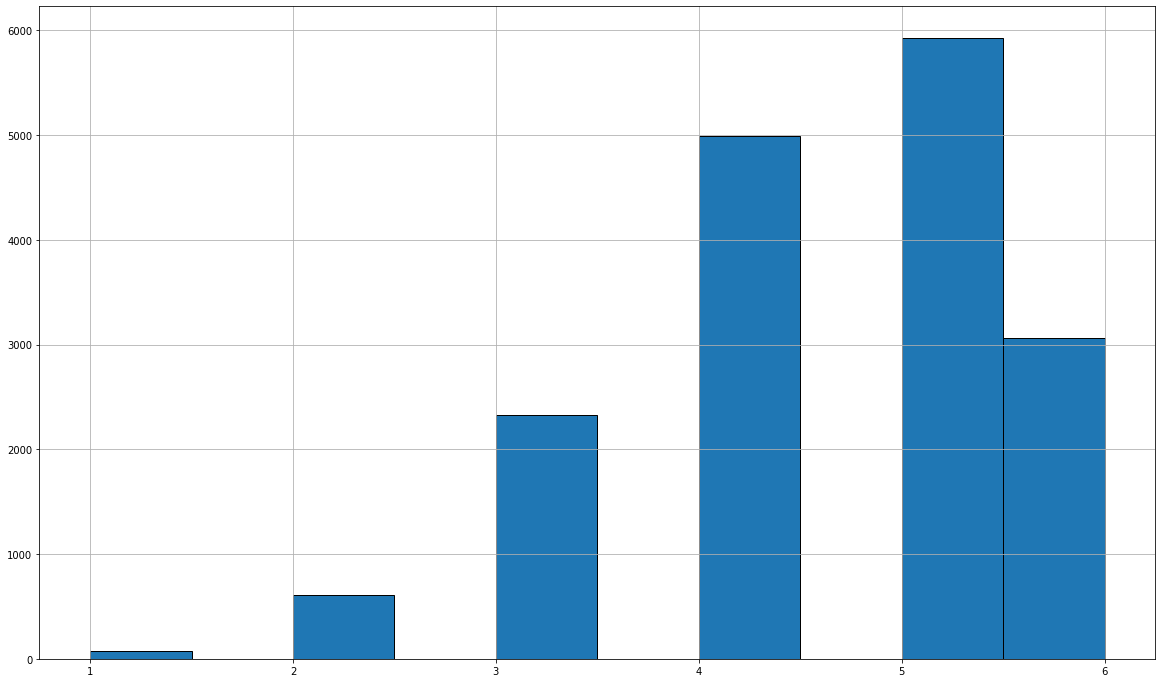

In [89]:
# define a offer received variable
transcript_portfolio3[transcript_portfolio3.event=='offer received'].groupby('person')['event'].count().hist(figsize = (20,12), edgecolor='black')

In [90]:
# define a offer received variable
num_offers = transcript_portfolio3[transcript_portfolio3.event=='offer received'].groupby(['person'])['event'].count().reset_index()
num_offers.rename(columns={'event':'num_offer_received'},inplace=True)
num_offers.head(10)

,person,num_offer_received
0,0009655768c64bdeb2e877511632db8f,5
1,00116118485d4dfda04fdbaba9a87b5c,2
2,0011e0d4e6b944f998e987f904e8c1e5,5
3,0020c2b971eb4e9188eac86d93036a77,5
4,0020ccbbb6d84e358d3414a3ff76cffd,4
5,003d66b6608740288d6cc97a6903f4f0,5
6,00426fe3ffde4c6b9cb9ad6d077a13ea,5
7,004b041fbfe44859945daa2c7f79ee64,3
8,004c5799adbf42868b9cff0396190900,5
9,005500a7188546ff8a767329a2f7c76a,5


In [91]:
# 6 people dont received any offer
transcript_portfolio3[transcript_portfolio3.event=='offer received'].person.nunique()

16994

In [92]:
# 6 people dont received any offer
num_offers.person.nunique()

16994

In [93]:
# fill NaN with 0 for offer received column
explore_bogo = explore_bogo.merge(num_offers,how='left',on=['person'])
explore_bogo['num_offer_received']=explore_bogo['num_offer_received'].fillna(value=0)
explore_discount = explore_discount.merge(num_offers,how='left',on=['person'])
explore_discount['num_offer_received']=explore_discount['num_offer_received'].fillna(value=0)
explore_informational = explore_informational.merge(num_offers,how='left',on=['person'])
explore_informational['num_offer_received']=explore_informational['num_offer_received'].fillna(value=0)

In [94]:
# head of explore bogo
explore_bogo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13220 entries, 0 to 13219
Data columns (total 12 columns):
person                13220 non-null object
offer_id              13220 non-null object
success               13220 non-null int64
age                   13220 non-null int64
became_member_on      13220 non-null datetime64[ns]
gender                12287 non-null object
income                12287 non-null float64
member_year           13220 non-null int64
member_month          13220 non-null int64
member_day            13220 non-null object
member_days           13220 non-null int64
num_offer_received    13220 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(6), object(4)
memory usage: 1.3+ MB


In [95]:
# drop missing values
explore_bogo.dropna(inplace=True)
explore_discount.dropna(inplace=True)
explore_informational.dropna(inplace=True)

In [96]:
# info of explore bogo
explore_bogo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12287 entries, 0 to 13219
Data columns (total 12 columns):
person                12287 non-null object
offer_id              12287 non-null object
success               12287 non-null int64
age                   12287 non-null int64
became_member_on      12287 non-null datetime64[ns]
gender                12287 non-null object
income                12287 non-null float64
member_year           12287 non-null int64
member_month          12287 non-null int64
member_day            12287 non-null object
member_days           12287 non-null int64
num_offer_received    12287 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(6), object(4)
memory usage: 1.2+ MB


In [97]:
explore_bogo.head()

,person,offer_id,success,age,became_member_on,gender,income,member_year,member_month,member_day,member_days,num_offer_received
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,40,2018-01-09,O,57000.0,2018,1,Tuesday,30,5
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,59,2016-03-04,F,90000.0,2016,3,Friday,820,5
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,24,2016-11-11,F,60000.0,2016,11,Friday,1060,4
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,24,2016-11-11,F,60000.0,2016,11,Friday,1060,4
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1,55,2018-05-08,F,74000.0,2018,5,Tuesday,150,3


In [98]:
# create dummy for the gender
def dummy(df, col):
    dum = pd.get_dummies(df[col])
    df = pd.concat([df, dum], axis=1, sort=False)
    return df

explore_bogo = dummy(explore_bogo, 'gender')
explore_discount = dummy(explore_discount, 'gender')
explore_informational = dummy(explore_informational, 'gender')

In [99]:
explore_bogo.head()

,person,offer_id,success,age,became_member_on,gender,income,member_year,member_month,member_day,member_days,num_offer_received,F,M,O
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,40,2018-01-09,O,57000.0,2018,1,Tuesday,30,5,0,0,1
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,59,2016-03-04,F,90000.0,2016,3,Friday,820,5,1,0,0
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,24,2016-11-11,F,60000.0,2016,11,Friday,1060,4,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,24,2016-11-11,F,60000.0,2016,11,Friday,1060,4,1,0,0
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1,55,2018-05-08,F,74000.0,2018,5,Tuesday,150,3,1,0,0


In [100]:
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1,0,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,1,0,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,0,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,0,1,0


In [101]:
# final data fromes used for ML model
explore_bogo = explore_bogo.merge(portfolio,how='left',on='offer_id')
explore_discount = explore_discount.merge(portfolio,how='left',on='offer_id')
explore_informational = explore_informational.merge(portfolio,how='left',on='offer_id')

In [102]:
explore_bogo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12287 entries, 0 to 12286
Data columns (total 27 columns):
person                12287 non-null object
offer_id              12287 non-null object
success               12287 non-null int64
age                   12287 non-null int64
became_member_on      12287 non-null datetime64[ns]
gender                12287 non-null object
income                12287 non-null float64
member_year           12287 non-null int64
member_month          12287 non-null int64
member_day            12287 non-null object
member_days           12287 non-null int64
num_offer_received    12287 non-null int64
F                     12287 non-null uint8
M                     12287 non-null uint8
O                     12287 non-null uint8
channels              12287 non-null object
difficulty            12287 non-null int64
duration              12287 non-null int64
offer_type            12287 non-null object
reward                12287 non-null int64
email         

# Implement

To recap what we have so far, for a person offer_id pair, we labeled using a ‘success’ variable whether the customer has successfully responded to the offer. We have engineered some features for the classification model. The random forest classifier will be implemented to train on our data.

Two functions are defined. The ‘feature_terget’ function is used to create feature and target variables for the classifier. ‘success’ is selected as the target label and other variables are used as features with an optional parameter ‘columns_to_drop’ to exclude variables you don’t want to use in the classifier. The ‘train_test’ function is implemented to split the data into train and test sets. StandardScaler is used to normalize the numerical variables and standardize features by removing the mean and scaling to unit variance.


In [103]:
# check the balance of the labels first, it's good for classification purpose
print(explore_bogo[['person','success']].groupby('success').count()/len(explore_bogo))
print(explore_discount[['person','success']].groupby('success').count()/len(explore_discount))
print((explore_informational[['person','success']].groupby('success').count()/len(explore_informational)))

          person
success         
0        0.17783
1        0.82217
           person
success          
0        0.135256
1        0.864744
           person
success          
0        0.252318
1        0.747682


In [104]:
def features_target(df, columns_to_drop):
    '''
    inputs:
    - df: prepared dataframe for modeling 
    - columns_to_drop: unneeded columns for feature
    outputs:
    - Returns features and target dataframes
    '''
    target = df['success']
    features = df.drop(columns_to_drop, axis=1, inplace=False)
    return features, target

In [105]:
# unneeded columns for features
columns_to_drop = ['person', 'offer_id', 'success', 'became_member_on', 'gender', 'member_year', 'member_month', 'member_day', 'channels', 'offer_type', 'bogo', 'discount', 'informational']

In [106]:
def train_test(features, target):
    '''
    inputs:
    - features & target dataframe 
    
    outputs:
    - Splits features and target dataframe to train and test sets, performs feature scaling on both datasets.
    - Outputs X_train, X_test, y_train and y_test dataframes
    '''
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=23)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

For the training and prediction process, I defined a function called ‘train_predict_model’, which takes the model used and train test data as input, trains the model on the data and returns the train and test accuracies and f1-scores.

In [107]:
def train_predict_model(model, X_train, y_train, X_test, y_test):
    '''
    inputs:
        - model: the model to be trained and predicted on
        - X_train: features training set
        - y_train: review_scores_rating training set
        - X_test: features testing set
        - y_test: review_scores_rating testing set
    outputs:
        - train test time and accuracies
    '''
    results = {}

    start = time() 
    model = model.fit(X_train, y_train)
    end = time() 
    results['train_time'] = end - start
    
    start = time() 
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    end = time() 
    results['pred_time'] = end - start
    
    results['training_score'] = model.score(X_train, y_train)
    results['testing_score'] = model.score(X_test, y_test)
     
    print("{} trained on {} samples.".format(model.__class__.__name__, len(y_train)))
    print("{} tested on {} samples.".format(model.__class__.__name__, len(y_test)))
    print(classification_report(y_train, pred_train, digits=4))
    print(classification_report(y_test, pred_test, digits=4))
    return results

To create an initial benchmark for the classifier, I decided to use a random forest classifier and manually set the classifier parameter as follows:  the ‘max_depth’ will be set to 10, the ‘max_features’ will be set as ‘auto’, the ‘min_samples_split’ will be set to 10, the ‘n_estimators’ will be set to 10, and the ‘min_samples_leaf’ will be set to 10. The basic idea is that we want to improve the performance of the model by tuning these parameters and the implementation will include the use of grid search. For the improved models, we will compare the scores with those from the benchmark classifier specified here.

In [108]:
# initialize the benchmark model
model_RF = RandomForestClassifier(random_state=2, max_depth=10, max_features='auto', min_samples_split=10, n_estimators=10, min_samples_leaf=10)

The three functions were implemented in order onto data of each offer. 

In [109]:
# prep for BOGO
features1, target1 = features_target(explore_bogo, columns_to_drop)
X_train1, X_test1, y_train1, y_test1 = train_test(features1, target1)

In [110]:
# train BOGO
results_RF_bogo = train_predict_model(model_RF, X_train1, y_train1, X_test1, y_test1)

RandomForestClassifier trained on 9829 samples.
RandomForestClassifier tested on 2458 samples.
              precision    recall  f1-score   support

           0     0.7592    0.1069    0.1874      1740
           1     0.8379    0.9927    0.9087      8089

   micro avg     0.8359    0.8359    0.8359      9829
   macro avg     0.7985    0.5498    0.5481      9829
weighted avg     0.8239    0.8359    0.7810      9829

              precision    recall  f1-score   support

           0     0.5536    0.0697    0.1238       445
           1     0.8276    0.9876    0.9006      2013

   micro avg     0.8214    0.8214    0.8214      2458
   macro avg     0.6906    0.5286    0.5122      2458
weighted avg     0.7780    0.8214    0.7599      2458



In [111]:
# BOGO results
results_RF_bogo

{'train_time': 0.04786992073059082,
 'pred_time': 0.012965679168701172,
 'training_score': 0.8358937837012921,
 'testing_score': 0.8213995117982099}

In [112]:
# prep for discount
features2, target2 = features_target(explore_discount, columns_to_drop)
X_train2, X_test2, y_train2, y_test2 = train_test(features2, target2)

In [113]:
# train discount
results_RF_discount = train_predict_model(model_RF, X_train2, y_train2, X_test2, y_test2)

RandomForestClassifier trained on 10179 samples.
RandomForestClassifier tested on 2545 samples.
              precision    recall  f1-score   support

           0     0.7609    0.0255    0.0493      1373
           1     0.8680    0.9988    0.9288      8806

   micro avg     0.8675    0.8675    0.8675     10179
   macro avg     0.8144    0.5121    0.4891     10179
weighted avg     0.8535    0.8675    0.8101     10179

              precision    recall  f1-score   support

           0     0.5000    0.0144    0.0279       348
           1     0.8647    0.9977    0.9265      2197

   micro avg     0.8633    0.8633    0.8633      2545
   macro avg     0.6823    0.5060    0.4772      2545
weighted avg     0.8148    0.8633    0.8036      2545



In [114]:
# discount results
results_RF_discount

{'train_time': 0.0448763370513916,
 'pred_time': 0.012965679168701172,
 'training_score': 0.8674722467825916,
 'testing_score': 0.8632612966601179}

In [115]:
# prep for informational
features3, target3 = features_target(explore_informational, columns_to_drop)
X_train3, X_test3, y_train3, y_test3 = train_test(features3, target3)

In [116]:
# train informational
results_RF_informational = train_predict_model(model_RF, X_train3, y_train3, X_test3, y_test3)

RandomForestClassifier trained on 5780 samples.
RandomForestClassifier tested on 1445 samples.
              precision    recall  f1-score   support

           0     0.7512    0.1117    0.1945      1432
           1     0.7715    0.9878    0.8664      4348

   micro avg     0.7708    0.7708    0.7708      5780
   macro avg     0.7613    0.5498    0.5304      5780
weighted avg     0.7665    0.7708    0.6999      5780

              precision    recall  f1-score   support

           0     0.4906    0.0665    0.1171       391
           1     0.7378    0.9744    0.8397      1054

   micro avg     0.7287    0.7287    0.7287      1445
   macro avg     0.6142    0.5204    0.4784      1445
weighted avg     0.6709    0.7287    0.6442      1445



In [117]:
# informational results
results_RF_informational

{'train_time': 0.036008596420288086,
 'pred_time': 0.008977174758911133,
 'training_score': 0.7707612456747405,
 'testing_score': 0.728719723183391}

To improve the model performance, grid search was used to obtain the best parameters of the classifier. The grid search function is defined below. The function was run on the training set of data of each offer type. The optimal parameters were obtained, then the classifiers were retrained with these parameters. 

In [118]:
# grid search for best prms
def RF_prm_search(X,y):
    '''
    input:
    - feature X frame and label y frame
    output:
    - parameter of the best model
    
    '''
    param_grid={'max_features': ['auto', 'sqrt'],
                'max_depth' : [10, 15],
                'n_estimators': [10, 20, 25, 30],
                'min_samples_split': [10, 20],
                'min_samples_leaf': [10, 15],
                }
    grid_search = GridSearchCV(RandomForestClassifier(random_state=2), param_grid)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [119]:
# bogo best prms
RF_prm_search(X_train1, y_train1)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 30}

In [120]:
# best bogo model
model_RF_bogo_best = RandomForestClassifier(random_state=2, max_depth=10, max_features='auto', min_samples_split= 10, n_estimators=30, min_samples_leaf=10)

In [121]:
# train bogo
results_RF_bogo_best = train_predict_model(model_RF_bogo_best, X_train1, y_train1, X_test1, y_test1)

RandomForestClassifier trained on 9829 samples.
RandomForestClassifier tested on 2458 samples.
              precision    recall  f1-score   support

           0     0.7626    0.0868    0.1558      1740
           1     0.8350    0.9942    0.9077      8089

   micro avg     0.8336    0.8336    0.8336      9829
   macro avg     0.7988    0.5405    0.5318      9829
weighted avg     0.8222    0.8336    0.7746      9829

              precision    recall  f1-score   support

           0     0.5455    0.0539    0.0982       445
           1     0.8256    0.9901    0.9004      2013

   micro avg     0.8206    0.8206    0.8206      2458
   macro avg     0.6855    0.5220    0.4993      2458
weighted avg     0.7749    0.8206    0.7551      2458



In [122]:
# bogo results
results_RF_bogo_best

{'train_time': 0.12285375595092773,
 'pred_time': 0.04000544548034668,
 'training_score': 0.8335537694577272,
 'testing_score': 0.8205858421480878}

In [123]:
# best prms for discount
RF_prm_search(X_train2, y_train2)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 15,
 'min_samples_split': 10,
 'n_estimators': 10}

In [124]:
# best discount model
model_RF_discount_best = RandomForestClassifier(random_state=2, max_depth=10, max_features='auto', min_samples_split= 10, n_estimators=10, min_samples_leaf=15)

In [125]:
# train discount
results_RF_discount_best = train_predict_model(model_RF_discount_best, X_train2, y_train2, X_test2, y_test2)

RandomForestClassifier trained on 10179 samples.
RandomForestClassifier tested on 2545 samples.
              precision    recall  f1-score   support

           0     0.7812    0.0182    0.0356      1373
           1     0.8672    0.9992    0.9285      8806

   micro avg     0.8669    0.8669    0.8669     10179
   macro avg     0.8242    0.5087    0.4820     10179
weighted avg     0.8556    0.8669    0.8081     10179

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       348
           1     0.8632    0.9991    0.9262      2197

   micro avg     0.8625    0.8625    0.8625      2545
   macro avg     0.4316    0.4995    0.4631      2545
weighted avg     0.7451    0.8625    0.7995      2545



In [126]:
# discount results
results_RF_discount_best

{'train_time': 0.046875715255737305,
 'pred_time': 0.013962030410766602,
 'training_score': 0.8668827979172806,
 'testing_score': 0.862475442043222}

In [127]:
# best prms for informational
RF_prm_search(X_train3, y_train3)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 20}

In [128]:
# best model informational
model_RF_informational_best = RandomForestClassifier(random_state=2, max_depth=10, max_features='auto', min_samples_split= 10, n_estimators=20, min_samples_leaf=10)

In [129]:
# train informational
results_RF_informational_best = train_predict_model(model_RF_informational_best, X_train3, y_train3, X_test3, y_test3)

RandomForestClassifier trained on 5780 samples.
RandomForestClassifier tested on 1445 samples.
              precision    recall  f1-score   support

           0     0.7700    0.1145    0.1994      1432
           1     0.7722    0.9887    0.8672      4348

   micro avg     0.7721    0.7721    0.7721      5780
   macro avg     0.7711    0.5516    0.5333      5780
weighted avg     0.7717    0.7721    0.7017      5780

              precision    recall  f1-score   support

           0     0.5000    0.0691    0.1213       391
           1     0.7383    0.9744    0.8401      1054

   micro avg     0.7294    0.7294    0.7294      1445
   macro avg     0.6192    0.5217    0.4807      1445
weighted avg     0.6738    0.7294    0.6456      1445



In [130]:
# informational results
results_RF_informational_best

{'train_time': 0.052860260009765625,
 'pred_time': 0.02293705940246582,
 'training_score': 0.7721453287197232,
 'testing_score': 0.7294117647058823}

# Result

If we compare the optimal classifiers with the benchmark classifiers, here are some observations. For BOGO, discount and informational offers, there are little improvements in the train and test accuracies, also the train and test f1-scores, because the benchmark model has almost the same train and test accuracies as the optimal model.

However, from these results, I believe the classification models are actually a big improvement in terms of helping the company better send out offers. Recall from the exploratory visualization section. Only 50% to 60% of customers successfully responded to the offers they received, in other words, the baseline conversion rate is 50% to 60%. For example, if we send out 10000 offers, then only 5000 of them are responded, and the remaining 5000 offers are actually ineffective. Meanwhile, if the classification models were implemented, the company will already know before sending out offers that which offers might be ineffective, with a fairly confidence level of about 80%. Instead of sending all 10000 offers, the company can target on the ‘success’ customers and save expenses by not sending offers to the ‘not success’ customers.

At the beginning of the project, I plan to build a machine learning classification model to predict whether a Starbuck customer will respond to a certain type of offer. We successfully created a classification model to predict whether a customer will respond to an offer, and we have achieved an accuracy score from 72.9% to 86.7%, and a f1-score from 64.9% to 80.8%, depending on the offer type. Aside from this, we also looked at the features importance, the results help the company better target the customers they should send out the offers and increase the revenue.

One thing I’m interested in is the feature importance. For example, if we have evidence that females are more responsive to the offers than males, the company can put more emphasis on female customers. I plotted the feature importance for each offer types and they are shown below.

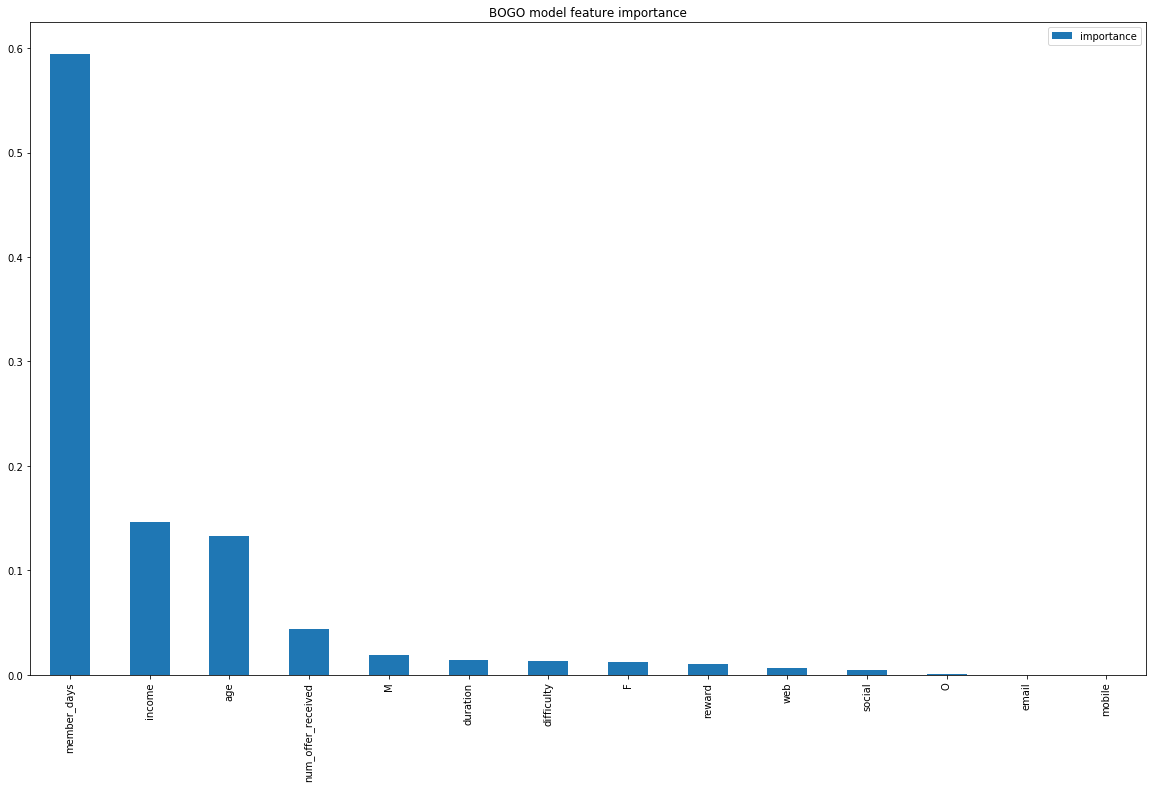

In [131]:
# feature imoprtance bogo
feature_importances1 = pd.DataFrame(model_RF_bogo_best.feature_importances_,
                                   index = features1.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances1.plot.bar(figsize =(20, 12))
plt.title('BOGO model feature importance')
plt.show()

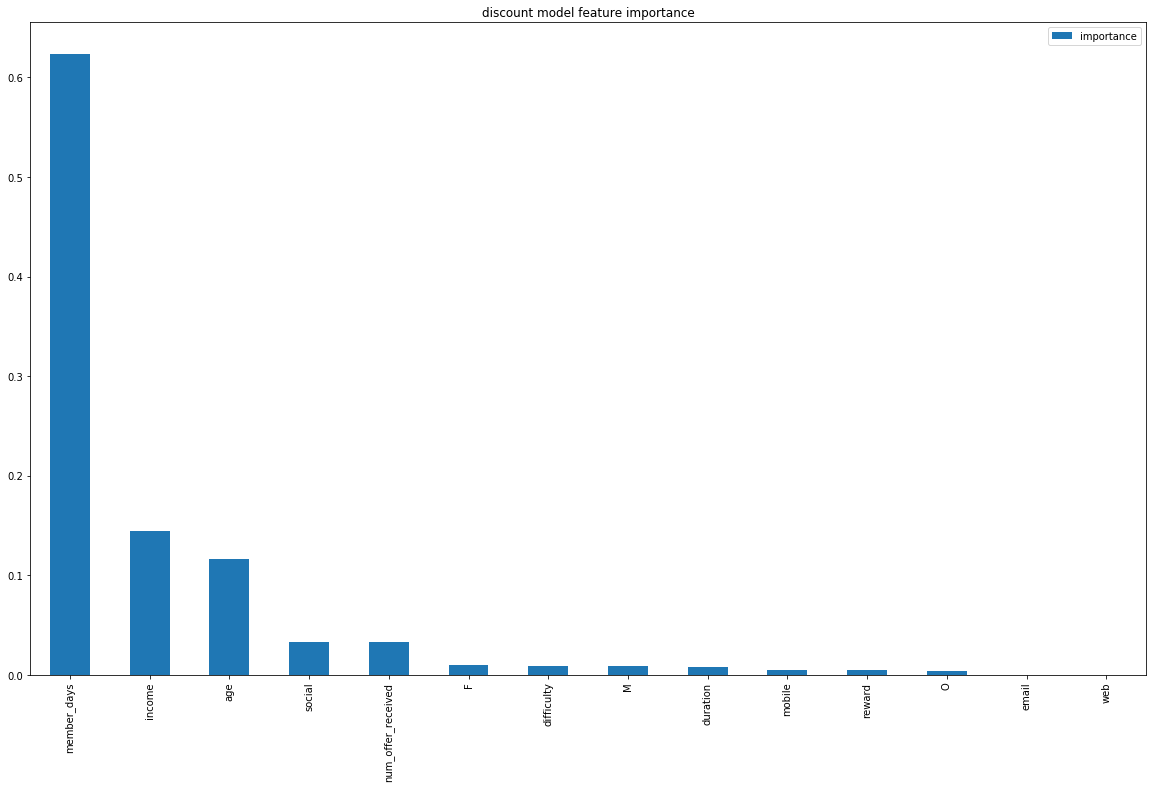

In [132]:
# feature imoprtance discount
feature_importances2 = pd.DataFrame(model_RF_discount_best.feature_importances_,
                                   index = features2.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances2.plot.bar(figsize =(20, 12))
plt.title('discount model feature importance')
plt.show()

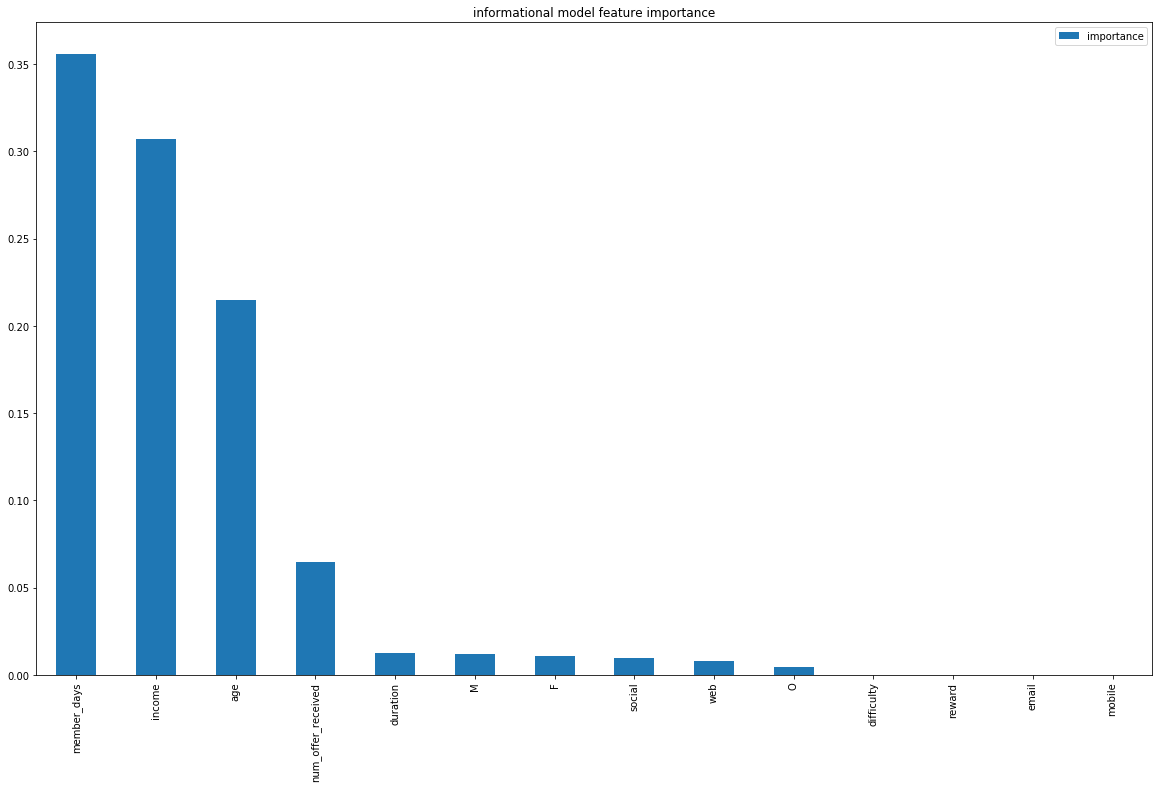

In [133]:
# feature imoprtance informational
feature_importances3 = pd.DataFrame(model_RF_informational_best.feature_importances_,
                                   index = features3.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances3.plot.bar(figsize =(20, 12))
plt.title('informational model feature importance')
plt.show()

For BOGO, discount and informational offers, membership day, income and age are the top 3 most important features, which actually confirms my assumption before that the longer the customers have used the app, the more likely they will make more purchases with the offer. It is noted that, while membership day dominates the BOGO and discount offer models, income and age are much more important for the informational offer model. This is understandable because both BOGO and discount offers have actual money reward, which means they provide cheaper products that are more affordable to the customers. Whereas for the informational offer, it seems that the customers will think about whether the ‘expensive’ products are worth their money.

There is always room for improvements. For example, we can use other classification models, such as decision tree to classify and compare with the random forest model. We can further engineer other features. For example, we can set up several age bins and explore the age dependence. Besides, we can also build machine learning regression models and predict the amounts the customers will spend when making purchases.

Last but not least, in this project, I focused on the customers who successfully (R-V-T-C) respond to the offers, or who fail to respond (R-V). Recall I mentioned before that there are other types of customers, such as customers who received the offer but didn’t view it, and loyal customers who would purchase the products regardless of offers. Exploratory analysis can be performed on those customers, or we can build classification models as well to identify them.
